# Max-$\kappa$-Colorable Subgraph QAOA Implementation

The Max-$\kappa$-Colorable Subgraph involves finding the largest subgraph of a given graph that can be colored using $\kappa$ colors, such that no two adjacent nodes share the same color. 

MaxCut is considered as a special case of graph coloring for $\kappa=2$ and therefore, after solving it with QAOA in the previous tutorial, provides us with a solid starting point for understanding graph coloring. The skills and knowledge you've gained are directly applicable here, but we'll also introduce new concepts and techniques to tackle the added complexity of using more than two colors.

You will explore how to formulate the M-$\kappa$-CS problem, implement the algorithm, and interpret the results. Along the way you'll likely realize that programming in Qrisp isn't a mundane black-and-white task, but rather a vibrant experience offering a whole spectrum of possibilities.

## From QuantumVariable to <span style="color:red">Q</span><span style="color:orange">u</span><span style="color:yellow">a</span><span style="color:green">n</span><span style="color:blue">t</span><span style="color:indigo">u</span><span style="color:violet">m</span><span style="color:red">C</span><span style="color:orange">o</span><span style="color:yellow">l</span><span style="color:green">o</span><span style="color:blue">r</span>

We start the tutorial by coding the <span style="color:red">Q</span><span style="color:orange">u</span><span style="color:yellow">a</span><span style="color:green">n</span><span style="color:blue">t</span><span style="color:indigo">u</span><span style="color:violet">m</span><span style="color:red">C</span><span style="color:orange">o</span><span style="color:yellow">l</span><span style="color:green">o</span><span style="color:blue">r</span> class, which is a custom [QuantumType](../../../reference/Quantum%20Types/index.rst) implemented and helps with tackling the Max-$\kappa$-Colorable-Subgraph problem. It provides flexibility in choosing encoding methods and leverages efficient data structures like QuantumArrays to enhance computational performance. Here is how to create a custom QuantumVariable class yourself to help you make your problem more compact.

In order to create your customized QuantumVariable, one first needs to import the [QuantumVariable](../../../reference/Core/QuantumVariable.rst) class. As mentioned before, using the [QuantumArray](../../../reference/Core/QuantumArray.rst) class leads to some shortcuts so let's import it as well. Before defining the class and functions within the class let's think about how one can describe or encode colors using strings of bits:

- One approach is to represent colors as an array where only one element is 1 and the rest are 0. For instance, if there are four colors, <span style="color:red">red</span>, <span style="color:green">green</span>, <span style="color:blue">blue</span>, and <span style="color:yellow">yellow</span>, they can be represented this way as <span style="color:red">[1, 0, 0, 0]</span>, <span style="color:green">[0, 1, 0, 0]</span>, <span style="color:blue">[0, 0, 1, 0]</span>, and <span style="color:yellow">[0, 0, 0, 1]</span>. This is called the **one-hot encoding**. 
- Another approach is to represent colors with a unique binary number. In the case of the same four colors, they can be represented, for example, as <span style="color:red">[0, 0]</span>, <span style="color:green">[0, 1]</span>, <span style="color:blue">[1, 0]</span>, and <span style="color:yellow">[1, 1]</span>, respectively. This encoding scheme is called **binary encoding**. 

In the code block below, we can define the initialization function ``__init__`` as well as find a way to tell our quantum algorithm which color is encoded with our array. In other words, we need to define a decoder function that will decode the color for a given index ``i``. In our case, we use the one-hot encoding scheme as default.

In [1]:
from qrisp import QuantumArray, QuantumVariable
import numpy as np

class QuantumColor(QuantumVariable):

    def __init__(self, list_of_colors, one_hot_enc = True): 
    
        self.list_of_colors = list_of_colors
        self.one_hot_enc = one_hot_enc

        if one_hot_enc:
            QuantumVariable.__init__(self, size = len(list_of_colors)) 
        else:
            QuantumVariable.__init__(self, size = int(np.ceil(np.log2(len(list_of_colors)))))

    def decoder(self, i):
    
        if not self.one_hot_enc:
            return self.list_of_colors[i]
        else:
            is_power_of_two = ((i & (i-1) == 0) and i != 0)

            if is_power_of_two:
                return self.list_of_colors[int(np.log2(i))]
            else:
                return "undefined"

The ``else`` condition returning "undefined" can come in extremely handy since it functions as an intuitive eye-test in the upcoming MkCS QAOA implementation. If any result of the simulation is "undefined", like [1, 0, 1, 0] for example, we know that something went wrong within our code.

The choice of encoding method has implications for how colors are represented in the quantum computation. Our simple QuantumColor class only needs a list of colors and a flag indicating the preferred encoding method as arguments. The breakdown above is meant to serve as inspiration for you, showcasing how custom QuantumVariables tailored to one specific problem can make life at least a little qubit more colorful.

Having already implemented this custom QuantumVariable, you can also simply import it via ``from qrisp.qaoa import QuantumColor``. In the example above we define a quantum box of crayons containing different colors. If one would then like to draw a meadow, one can take the green one out of the box and initialize a color using ``box_of_crayons[:] = "green"``. 

Run the code box below and see how that works with our custom QuantumVariable.

In [2]:
from qrisp.qaoa import QuantumColor

color_list = ["red", "orange", "yellow", "green", "blue", "violet"]
box_of_crayons = QuantumColor(color_list)
box_of_crayons[:] = "green"
print(box_of_crayons.qs)

QuantumCircuit:
---------------
box_of_crayons.0: ─────
                       
box_of_crayons.1: ─────
                       
box_of_crayons.2: ─────
                  ┌───┐
box_of_crayons.3: ┤ X ├
                  └───┘
box_of_crayons.4: ─────
                       
box_of_crayons.5: ─────
                       
Live QuantumVariables:
----------------------
QuantumColor box_of_crayons


With the knowledge we obtained above under our sleeve the only thing left to do now is is to tackle the colorless Max-$\kappa$-Colorable Subgraph and implement QAOA in style!

## M$\kappa$CS meets QAOAProblem

Let's revisit the recipe from the previous tutorial; to implement QAOA with [QAOAProblem](/reference/QAOAProblem) one needs to *drumroll please...*

I. define the **CLASSICAL COST FUNCTION** of the problem, 
II. define the **INITIAL STATE** if it is not the superposition, which in the case of graph coloring indeed is not,  
III. define **COST OPERATOR aka PHASE SEPARATOR** (or use the ones specified in [From QAOA to QAOA](https://arxiv.org/abs/1709.03489)), and 
IV. select **MIXER** from the [assortment we provide and list here](/reference/MIXers).

Time to prepare the ingrediends starting with defining a graph and the available colors we'd like to color the graph with.

In [3]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([[0,3],[0,1],[0,2],[1,3],[1,2],[2,3]])
num_nodes = len(G.nodes)

color_list = ["red", "blue", "yellow", "green"]

Before defining the classical cost function ``cl_cost_function(meas_res)`` for M$\kappa$CS we need to think about the objective (``mkcs_obj``). Since we're trying to color a graph in a way to prevent neighboring nodes being the same color, we will reward the instances where they are in fact not the same color. To increase the contrast between optimal and less optimal solutions we shall use multiplicaton for the aforementioned reward instead of simple addition. This little trick can already improve the results significantly instead of using the standard approach.

After iterating over all edges of graph ``G``, the objective function ``mkcs_obj`` returns an integer value of the free energy objective function. The remaining of the definition

In [4]:
def mkcs_obj(color_array, G):
   
    cost = 1

    for pair in list(G.edges()):

        if color_array[pair[0]] != color_array[pair[1]]:
           cost *= 4
           # Instead of
           #cost += 1

    return -cost

is similar to the one for MaxCut in the sense that calculates the relative energy in respect to the probability for each sample. Iteration over all items to calculate the objective function for current measurement is the same as in the MaxCut implementation, as is returning the energy calculated using the ``mkcs_obj`` objective funcion. Note that we don't need to normalize, since the measurement results are probabilities rather than counts.

In [5]:
def cl_cost_function(meas_res):
    
    energy = 0

    for meas, prob in list(meas_res.items())[::-1]:
    
        obj_for_meas = mkcs_obj(meas, G)
            
        energy += obj_for_meas * prob
    
    return energy

As spoiled before, the superposition state is not the ideal initial state in this particular case. In principle a superposition state is viable, however, it needs to respect the one-hot encoding constraint. Instead we simply pick a random initial coloring of all the nodes and trust the QAOA to do the rest.

To do this one first needs to import randomness and define the quantum argument ``qarg``, which is in this case a [QuantumArray](/reference/QuantumArray) of QuantumColors. After setting the initial set to a random coloring, we then define a function that sets all elements in ``qarg`` to the initial state.

In [6]:
import random
    
qarg = QuantumArray(qtype = QuantumColor(color_list), 
                    shape = num_nodes) 
    
init_state = [random.choice(color_list) for _ in range(len(G))]

def initial_state_mkcs(qarg):
    qarg[:] = init_state
    return qarg

Following along with the recipe in hand is taking care of the coloring operator. For simplicity and code readability reasons we first define ``apply_phase_if_eq``, which indeed applies a phase if the colors of two arguments are matching. Having defined this, constructing the coloring operator is as easy as going through the list of all edges in our graph.

In [7]:
from qrisp import cp, cx, mcp
def apply_phase_if_eq(qcolor_0, qcolor_1, gamma):
    
    if qcolor_0.one_hot_enc !=  qcolor_1.one_hot_enc or len(qcolor_0) != len(qcolor_1):
        raise Exception("Tried to compare QuantumColors with differing encodings")
    
    if qcolor_0.one_hot_enc:
        for i in range(qcolor_0.size):
            # If the i-th qubit is "1" for both variables they represent the same color
            # In this case the cp gate applies a phase of 2*gamma
            cp(2*gamma, qcolor_0[i], qcolor_1[i])

    else:
        # If both quantum variables are in the same state the following cx gates will
        # put qcolor_1 in the |0> state
        cx(qcolor_0, qcolor_1)
        # We apply the phase 2*gamma to the |0> state using a multi-controlled phase gate
        mcp(2*gamma, qcolor_1, ctrl_state = 0)
        # Revert the action of the cx gate
        cx(qcolor_0, qcolor_1)
    
def create_coloring_operator(G):
    
    def coloring_operator(quantumcolor_array, gamma):
        for pair in list(G.edges()):
            apply_phase_if_eq(quantumcolor_array[pair[0]], quantumcolor_array[pair[1]], gamma)
    return coloring_operator 

We can see the advantage of the one-hot encoding: It might require more qubits but the comparison of two colors only requires one [cp](../../../reference/Primitives/generated/qrisp.cp.rst) gate per color. The binary encoding requires significantly less qubits but also an [mcp](../../../reference/Primitives/generated/qrisp.mcp.html) gate, which is more costly, especially on near-term hardware.

To season everything we need to decide on which [mixer](../../../reference/Algorithms/qaoa/QAOAMixers.rst) to choose to allow the transitions between different colorings. As proposed in [QAOAnsatz](https://arxiv.org/abs/1709.03489)  we will use the XY mixer aka the parity ring mixer. As for the binary encoding the X mixer we used in MaxCut works fine as well.

In [8]:
from qrisp.qaoa import XY_mixer, RX_mixer

def apply_XY_mixer(quantumcolor_array, beta):
    for qcolor in quantumcolor_array:
        XY_mixer(qcolor, beta)
    return quantumcolor_array

Putting all the ingredients we just prepared into the methaphorical oven, which is in this case actually the [QAOAProblem](../../../reference/Algorithms/qaoa/QAOAProblem.rst) class, we can now simply run the algorithm following the same steps as in the previous tutorial before a marvelous masterpiece - the correctly colored graph - manifests into existence. 

Let's speedrun through the steps we already got familiar with in the previous tutorial:

- define the depth $p$ of our QAOA algorithm. 
- create the ``coloring operator``
- create the ``coloring_instance`` problem instance with ``QAOAProblem``
- set initial state using the ``.set_init_function`` method
- run QAOA using the ``.run`` method
- display the solution.

And most importantly: whisper the magic word: *QRISPIFYYY*

Best string: ['red' 'yellow' 'green' 'blue'] with coloring: 4096                     
QAOA solution:  ['red' 'yellow' 'green' 'blue']


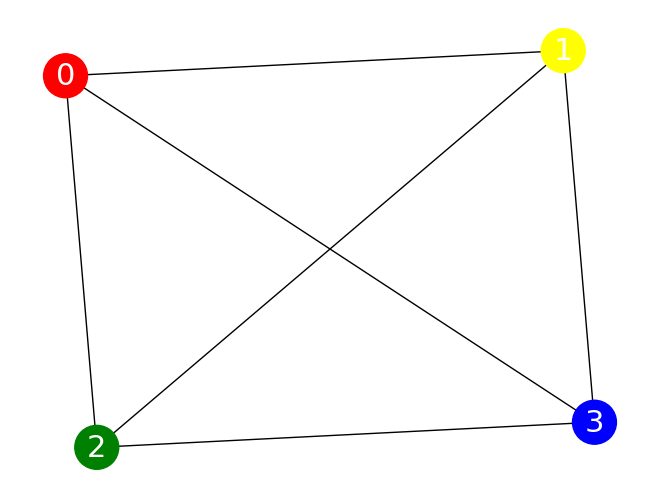

In [9]:
from qrisp.qaoa import QAOAProblem
from operator import itemgetter

depth = 3

coloring_operator = create_coloring_operator(G)

coloring_instance = QAOAProblem(coloring_operator, apply_XY_mixer, cl_cost_function) 
#coloring_instance = QAOAProblem(coloring_operator, RX_mixer, cl_cost_function) #Use RX mixer for binary encoding

coloring_instance.set_init_function(initial_state_mkcs)

res = coloring_instance.run(qarg, depth, max_iter = 25)

best_coloring, best_solution = min([(mkcs_obj(quantumcolor_array,G),quantumcolor_array) for quantumcolor_array in res.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with coloring: {-best_coloring}")

best_coloring, res_str = min([(mkcs_obj(quantumcolor_array,G),quantumcolor_array) for quantumcolor_array in list(res.keys())[:5]], key=itemgetter(0))
print("QAOA solution: ", res_str)
best_coloring, best_solution = (mkcs_obj(res_str,G),res_str)

colors = [res_str[node] for node in G.nodes()]
nx.draw(G, with_labels = True, font_color='white', node_size=1000, font_size=22, node_color = colors)

🎉 aaand time! Whew, a new personal best! 🎉

One can now benchmark the approach using the [benchmark](../../..reference/Algorithms/qaoa/generated/qrisp.qaoa.QAOAProblem.benchmark.rst) method following the same procedure as explained in the MaxCut QAOA tutorial, and conquer a complex problem instance like the Max-$\kappa$-Coloring Subgraph using Qrisp and the plethora of useful functionalities and customizabilities it brings.

## Summary and motivation

To sum up:
- you created a colorful custom QuantumType known as QuantumColor; 
- you explored two different color encoding techniques: one-hot encoding and binary encoding; 
- a crucial step that cannot be overstated is the importance of elegantly specifying a complex problem instance using the four-step-recipe we provided before running QAOA using the ``.run`` method of the ``QAOAProblem`` class. 

It's pedagogical to, similarly to what we have done in the previous MaxCut tutorial, provide a condensed code block of the full M$\kappa$CS QAOA implementation using our predefined functions and show how elegantly one can tackle this complex problem.

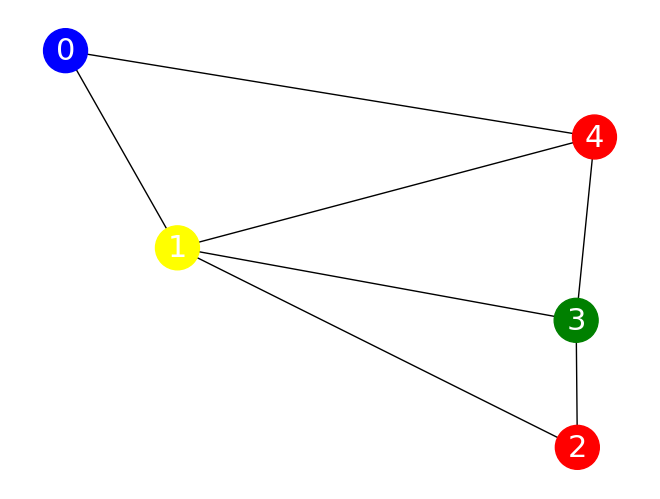

In [11]:
from qrisp.qaoa import QuantumArray, QuantumColor, QAOAProblem, mkcs_obj, create_coloring_operator, create_coloring_cl_cost_function, apply_XY_mixer
import random
import networkx as nx
from operator import itemgetter

depth = 3

G = nx.Graph()
G.add_edges_from([[0,1],[0,4],[1,2],[1,3],[1,4],[2,3],[3,4]])
num_nodes = len(G.nodes)
color_list = ["red", "blue", "yellow", "green"]
init_state = [random.choice(color_list) for _ in range(len(G))]

qarg = QuantumArray(qtype = QuantumColor(color_list, one_hot_enc = True), shape = num_nodes) 
mkcs_onehot = QAOAProblem(create_coloring_operator(G), apply_XY_mixer, create_coloring_cl_cost_function(G))
mkcs_onehot.set_init_function(lambda x : x.encode(init_state))

res_onehot = mkcs_onehot.run(qarg, depth, max_iter = 25)

best_coloring, best_solution = min([(mkcs_obj(quantumcolor_array,G),quantumcolor_array) for quantumcolor_array in res_onehot.keys()], key=itemgetter(0))
best_coloring_onehot, res_str_onehot = min([(mkcs_obj(quantumcolor_array,G),quantumcolor_array) for quantumcolor_array in list(res_onehot.keys())[:5]], key=itemgetter(0))

colors = [res_str_onehot[node] for node in G.nodes()]
nx.draw(G, with_labels = True, font_color='white', node_size=1000, font_size=22, node_color = colors)

After successfully coloring the graph, you now possess the sacred knowledge of understanding how to implement QAOA in Qrisp to solve complex optimization problems. 

But wait, there's more! Let us quickly invite you to continue with the next tutorial in this QAOA section titled Channelled Constrained Mixers where you will learn how to construct and utilize channelled constrained mixers for QAOA - a novel concept which will be detailed in an upcoming scientific publication. It also includes a cool intuitive comparison of the whole QAOA mixing process to the well known multi-slit experiment!

Without further ado: let's test Qrisp to its limits and MIX IT UP!